## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import spacy
import warnings
warnings.filterwarnings('ignore')
from spacy import displacy
import networkx as nx
import os
import re 
import matplotlib.pyplot as plt
from pyvis.network import Network
from spacy.cli import download
from utils.functions import *
import community as community_louvain


download("en_core_web_sm")
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
# Read characters
characters_df = pd.concat([pd.read_csv("major_lor_characters.csv", usecols=['Name']), pd.read_csv("hobbit_characters.csv", usecols=['Name'])]).reset_index(drop=True)


### Fixing names I

In [5]:
fix=[]

I = ['Tom','Bert','William','Fíli','Kíli','Elladan','Elrohir']

for i in range(0,len(I)):
    fix.append({'Name': I[i]})
    
IndextoDrop = [characters_df[characters_df['Name']=='Tom, Bert, and William'].index[0],characters_df[characters_df['Name']=='Fíli and Kíli'].index[0]
                    ,characters_df[characters_df['Name']=='Elladan and Elrohir'].index[0]]

characters_df.drop(IndextoDrop, axis=0, inplace=True)

characters_df =  pd.concat([characters_df,pd.DataFrame(fix)]).reset_index(drop=True)

### Fixing names II

In [6]:
# Remove brackets and text within brackets
characters_df['Name'] = characters_df['Name'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
# Separating first names
characters_df['Firstname'] = characters_df['Name'].apply(lambda x: x.split(' ', 1)[0])

In [7]:
characters_df.iloc[characters_df[(characters_df['Firstname']=='Master')].index.values[0],-1]=characters_df.iloc[characters_df[(characters_df['Firstname']=='Master')].index.values[0],0]
pd.set_option('display.max_rows', None)
characters_df

,Name,Firstname
0,Aragorn II Elessar,Aragorn
1,Arwen,Arwen
2,Frodo Baggins,Frodo
3,Beregond,Beregond
4,Bergil,Bergil
5,Bilbo Baggins,Bilbo
6,Fredegar Bolger,Fredegar
7,Tom Bombadil,Tom
8,Boromir,Boromir
9,Meriadoc Brandybuck,Meriadoc


### Evolution of characters importance

In [13]:
# Initialize empty list for graphs from books
books_graph = []
#and b.name 

all_books = [b for b in os.scandir('books') if ('.txt' in b.name) and b.name not in ['04 - LOR.txt']]

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)


# Setting nlp max_length
for file in all_books:
    with open(file, 'r', errors="ignore") as f:
        text = f.read()
        f.close()
    if nlp.max_length < len(text) + 100:
        nlp.max_length = len(text) + 100
    

724795
1021931
1021931
1021931


In [14]:
# Loop through book list and create graphs
for book in all_books:
    
    with open(book,  'r', encoding='utf-8') as t:
        book_text=nlp(t.read())
        t.close()
    
    # Get list of entities per sentences
    sent_entity_df = entity_tag(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    # Create relationship df
    relationship_df = window_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

<Figure size 720x720 with 0 Axes>

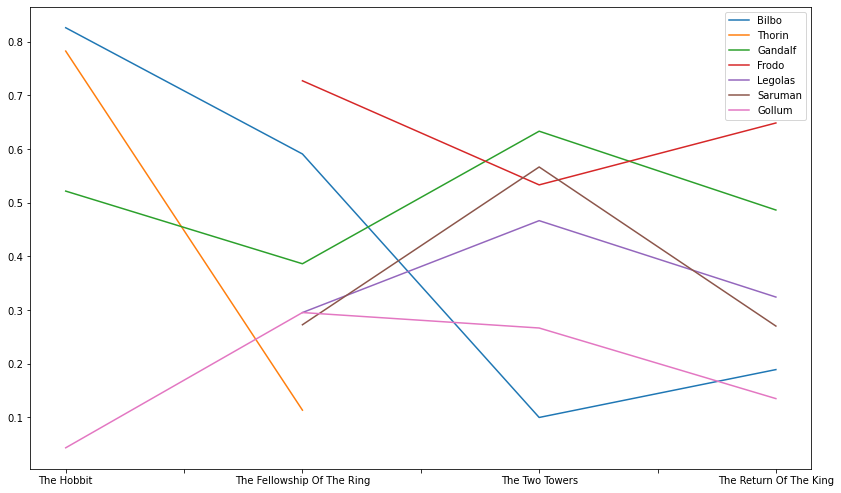

In [86]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)
degree_evol_df.rename(index={0: 'The Hobbit', 1: 'The Fellowship Of The Ring', 2:'The Two Towers', 3:'The Return Of The King'}, inplace=True)


plt.figure(figsize=(10,10))
# Plotting the degree centrality evolution of 5 main characters
fig, ax = plt.subplots(figsize = (14, 8.5));
degree_evol_df[["Bilbo", "Thorin", "Gandalf", "Frodo", "Legolas", "Saruman", "Gollum"]].plot(ax=ax);

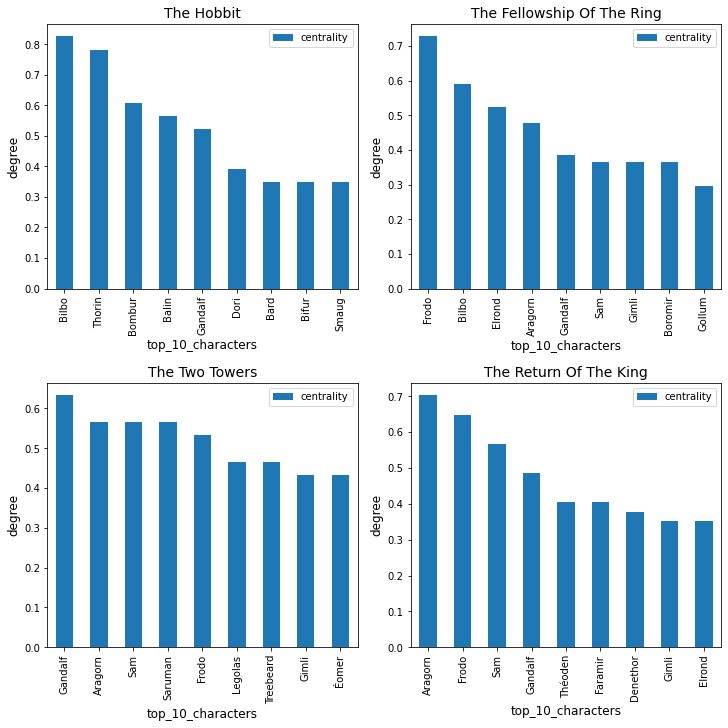

In [87]:

dict_book_name ={0: 'The Hobbit', 1: 'The Fellowship Of The Ring', 2:'The Two Towers', 3:'The Return Of The King'}
def degree(G,ax,book_name):
    ax.set_title(book_name, fontsize=14)
    ax.set_xlabel('top_10_characters', fontsize=12)
    ax.set_ylabel('degree', fontsize=12)
    # Degree centrality
    df = pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index', columns=['centrality'])
    df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar",ax=ax);

fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2, constrained_layout=True)
for i,ax in enumerate(axs.flat):
    degree(books_graph[i],ax,dict_book_name[i])

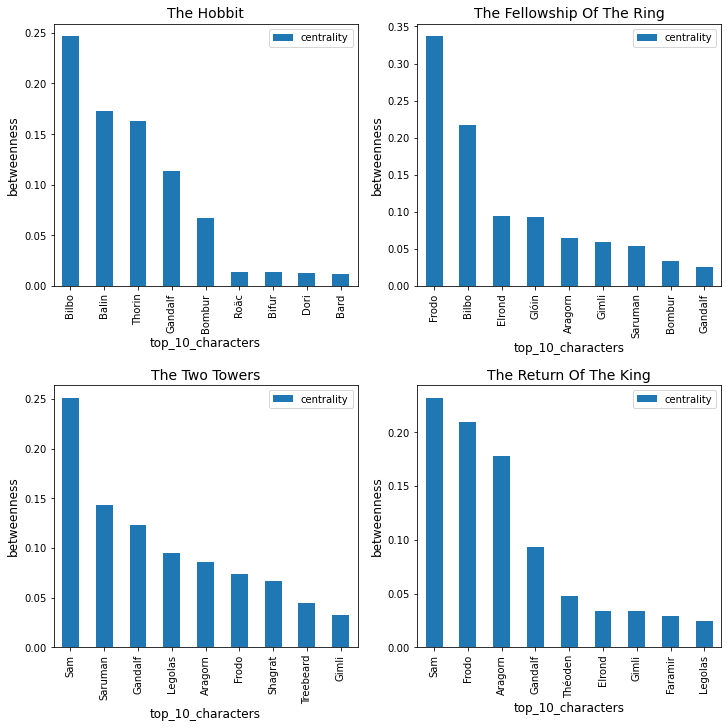

In [88]:
def betweenness(G,ax,book_name):
    ax.set_title(book_name, fontsize=14)
    ax.set_xlabel('top_10_characters', fontsize=12)
    ax.set_ylabel('betweenness', fontsize=12)
    # Degree centrality
    df = pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index', columns=['centrality'])
    df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar",ax=ax);

fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2, constrained_layout=True)
for i,ax in enumerate(axs.flat):
    betweenness(books_graph[i],ax,dict_book_name[i])

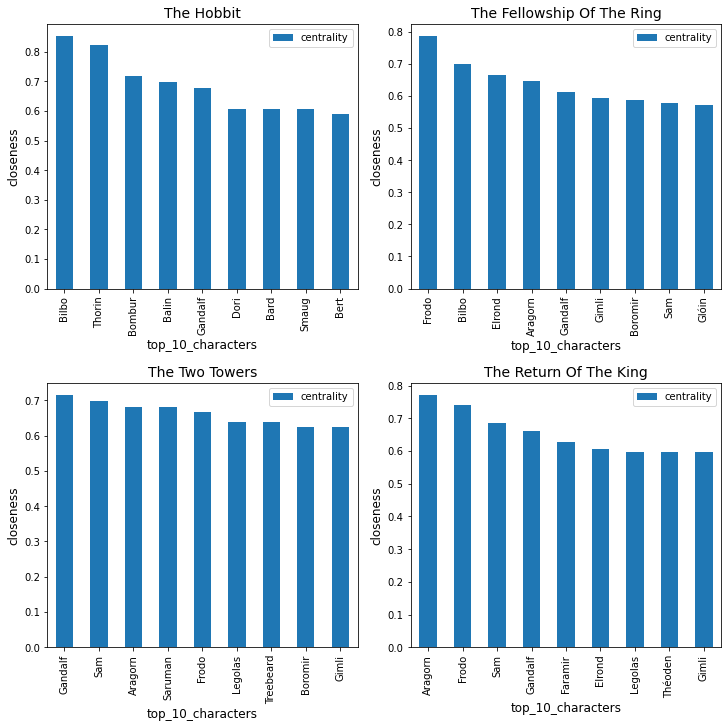

In [89]:
def closeness(G,ax,book_name):
    ax.set_title(book_name, fontsize=14)
    ax.set_xlabel('top_10_characters', fontsize=12)
    ax.set_ylabel('closeness', fontsize=12)
    # Degree centrality
    df = pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index', columns=['centrality'])
    df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar",ax=ax);

fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2, constrained_layout=True)
for i,ax in enumerate(axs.flat):
    closeness(books_graph[i],ax,dict_book_name[i])

## Graph visualization - Pyvis

In [72]:


for i,g in enumerate(books_graph):
    net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

    node_degree = dict(books_graph[i].degree)

    #Setting up node size attribute
    nx.set_node_attributes(books_graph[i], node_degree, 'size')
    net.from_nx(books_graph[i])
    net.show(book_name[i]+".html")

In [77]:
net.show('The Hobbit.html')

In [74]:
net.show('The Fellowship Of The Ring.html')

In [75]:
net.show('The Two Towers.html')

In [76]:
net.show('The Return Of The King.html')

# Community detection

In [68]:
# Saving centrality measures
for i in books_graph:
    nx.set_node_attributes(i, nx.degree_centrality(i), 'degree_centrality')
    nx.set_node_attributes(i, nx.betweenness_centrality(i), 'betweenness_centrality')
    nx.set_node_attributes(i, nx.closeness_centrality(i), 'closeness_centrality')

In [79]:
for i,g in enumerate(books_graph):
    com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

    communities = community_louvain.best_partition(g)
    #Setting up node size attribute
    nx.set_node_attributes(g, communities, 'group')
    com_net.from_nx(g)
    com_net.show(book_name[i]+"_communities.html")



In [82]:
com_net.show('The Hobbit_communities.html')

In [83]:
com_net.show('The Fellowship Of The Ring_communities.html')

In [84]:
com_net.show('The Two Towers_communities.html')

In [85]:
com_net.show('The Return Of The King_communities.html')